In [1]:
%reload_ext autoreload
%matplotlib notebook
import os, sys
import logging
import random
import h5py
import shutil
import time
import argparse
import numpy as np
import sigpy.plot as pl
import torch
import sigpy as sp
import torchvision
from torch import optim
import scipy.ndimage
from scipy.ndimage import binary_closing
from tensorboardX import SummaryWriter
from torch.nn import functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib
# import custom libraries
from utils import transforms as T
from utils import subsample as ss
from utils import complex_utils as cplx
from utils.resnet2p1d import generate_model
from utils.flare_utils import roll
#from utils import data_ut as dut
# import custom classes
from utils.datasets import SliceData
from subsample_fastmri import MaskFunc
from MoDL_single import UnrolledModel
import argparse
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib
from models.SAmodel import MyNetwork
from models.Unrolled import Unrolled
from ImageFusion_Dualbranch_Fusion.densefuse_net import DenseFuseNet
from ImageFusion_Dualbranch_Fusion.channel_fusion import channel_f as channel_fusion
import ut2 as ut

from RCAN import CombinedNetwork
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
%load_ext autoreload
%autoreload 0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


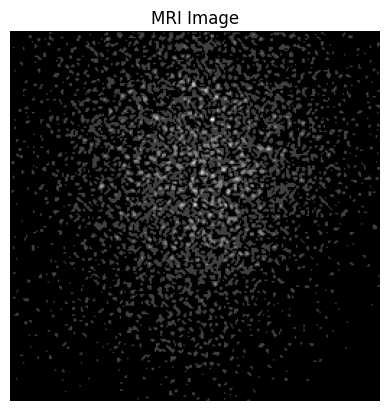

In [2]:
import pydicom
import matplotlib.pyplot as plt

# Load the DICOM file
dicom_file = "./3T_data_PROMRI/TEST_SPECTRO_PHANTOM.MR.AMRI_LAB_OUD.0008.0001.2023.01.24.19.24.17.358231.98866291.IMA"
dicom_data = pydicom.dcmread(dicom_file)

# Extract the image data from the DICOM file
image_data = dicom_data.pixel_array

# Plot the image
plt.imshow(image_data, cmap="gray")
plt.title("MRI Image")
plt.axis("off")
plt.show()

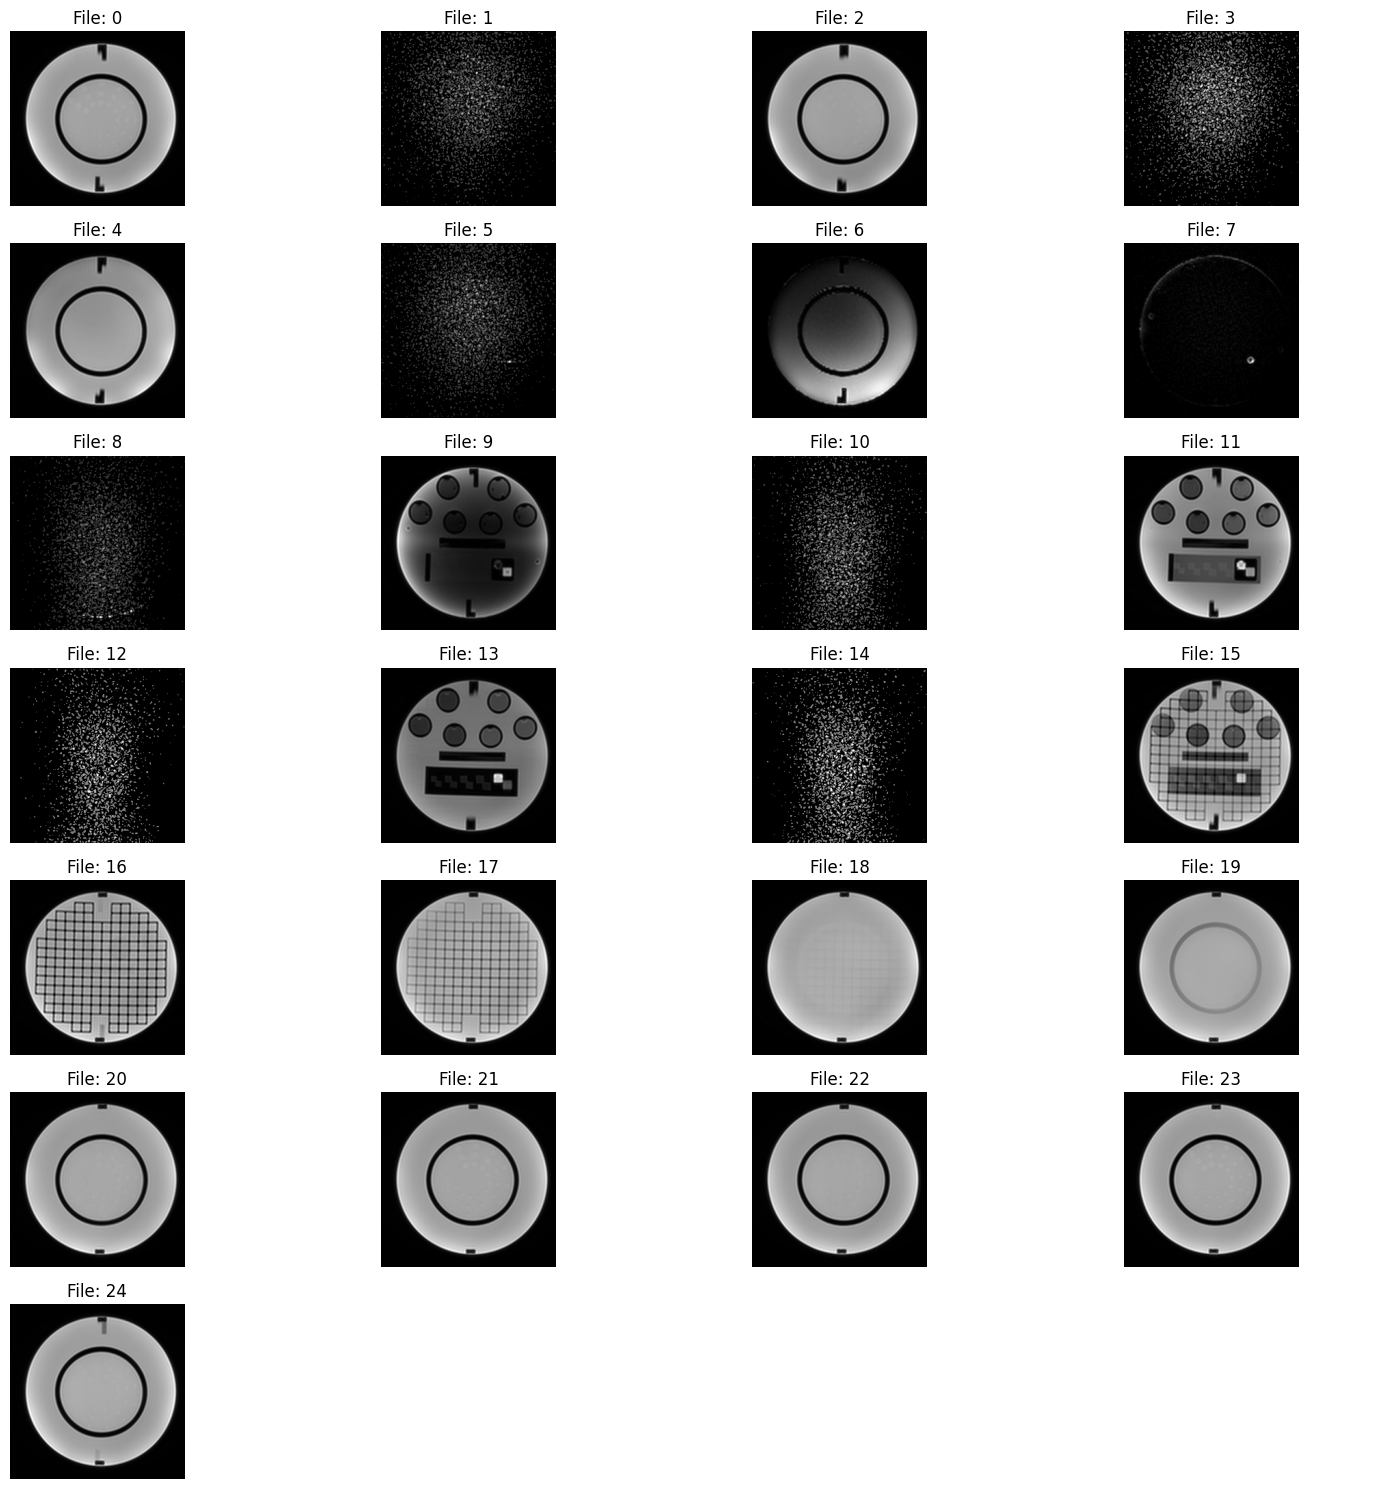

(256, 256)
(155, 155, 1)


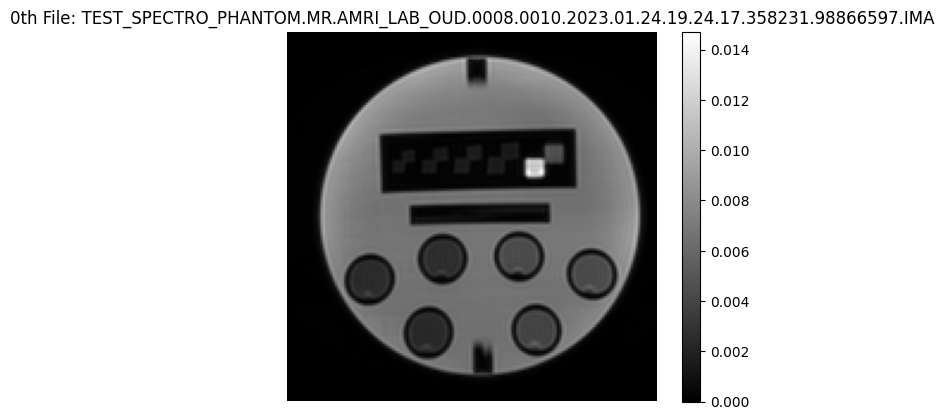

In [84]:
# Directory containing your DICOM files
dicom_dir = "./3T_data_PROMRI/"

files = [f for f in os.listdir(dicom_dir) if f.endswith(".IMA")]

# Set up the subplot grid
n_files = len(files)
n_cols = 4  # Set the number of columns for subplots
n_rows = (n_files + n_cols - 1) // n_cols  # Calculate rows based on number of files

# Create a figure and subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 15))

# Flatten the axs array in case it's 2D (for easy iteration)
axs = axs.flatten()

# Loop through the files and plot in subplots
for i, filename in enumerate(files):
    dicom_file = os.path.join(dicom_dir, filename)
    dicom_data = pydicom.dcmread(dicom_file)
    image_data = dicom_data.pixel_array

    # Plot the image on the ith subplot
    axs[i].imshow(image_data, cmap="gray")
    axs[i].set_title(f"File: {i}")
    axs[i].axis("off")
    if i == 13:
        reference = image_data

# Hide any remaining empty subplots
for ax in axs[n_files:]:
    ax.axis("off")

print()
# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()
print(reference.shape)


## Resize as Low-Field 
from skimage.transform import resize
image = np.flipud(reference)  # Replace with your actual image array
# Resize the image to 155x155
resized_image = resize(image, (172, 108), anti_aliasing=True)
resized_image = resize(image, (155, 155), anti_aliasing=True)

## Save
arr_3d = np.expand_dims(resized_image, axis=-1) 
print(arr_3d.shape)
affine = np.eye(4)
nii_img = nib.Nifti1Image(arr_3d, affine)
nib.save(nii_img, './ULFdata/HF4.nii')

plt.imshow(resized_image, cmap="gray")
plt.colorbar()
plt.title(f"0th File: {files[17]}")
plt.axis("off")
plt.show()

In [4]:

import numpy as np


file_3d = "./LFdata/data.3d"  # replace with your actual file
data_3d = np.fromfile(file_3d, dtype=np.float32)  # Assuming float32, adjust as needed
# Total number of elements in the file
num_elements = data_3d.size
print(data_3d[2].shape)
print(f"Total number of elements: {num_elements}")


()
Total number of elements: 1201258


Shape: (155, 155, 25)


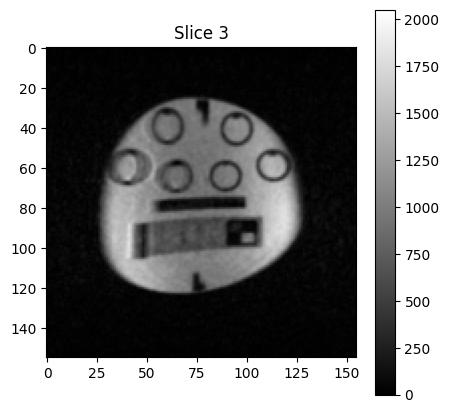

(155, 155)
(155, 155, 1)


In [93]:
data_folder = './LFdata/'
sub_folder = ''
fname_nii = './ULFdata/ULF4.nii'

from read_kea3d import kea3d
from kea2nifti import make_nifti
from nibabel.viewers import OrthoSlicer3D

sample_data = kea3d(data_folder=data_folder, sub_folder=sub_folder)
kspace = sample_data.kspace_gauss_filter

## Pad kspace for equal resolution
# Original k-space dimensions
original_shape = kspace.shape  # (H, W)
print(f'Shape: {kspace.shape}')
# Define the new size for dimension 1
new_dim1 = int(original_shape[1] * 1)  # Example: increase by 50%

# Calculate padding for dimension 1
pad_dim1_before = (new_dim1 - original_shape[1]) // 2
pad_dim1_after = new_dim1 - original_shape[1] - pad_dim1_before

# Apply zero-padding along dimension 1
kspace = np.pad(
    kspace,
    pad_width=((0, 0), (pad_dim1_before, pad_dim1_after), (0, 0)),  # Pad dimension 1
    mode="constant",
    constant_values=0,
)

im = np.fft.fftshift(np.fft.fftn((np.fft.fftshift(kspace))))
slice_num = 3
im = resize(np.abs(im[:,:,slice_num]), (155, 155), anti_aliasing=True)
#s = OrthoSlicer3D(np.abs(im))
#s.clim =[0, 2048]
#s.cmap = 'gray'
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
plt.imshow(np.flipud(np.abs(im)), cmap='gray', vmin=0, vmax=2048)
plt.colorbar()
plt.title(f'Slice {slice_num}')
plt.show()

print(im.shape)
# Make nifti in case of need for further inputs to other software 
# Determine resolution from acq_par
arr_3d = np.expand_dims(np.abs(im), axis=-1) 
print(arr_3d.shape)
affine = np.eye(4)
nii_img = nib.Nifti1Image(arr_3d, affine)


#nib.save(nii_img, fname_nii)



In [6]:
!pwd

/home/taloved/.bashrc: line 5: ${BART TOOLBOX PATH}: bad substitution
/home/taloved/tal-lxc/tal/docker/MoDLsinglechannel/modl_singlechannel_reference


In [7]:
!which python3

/home/taloved/.bashrc: line 5: ${BART TOOLBOX PATH}: bad substitution
/home/taloved/env/bin/python3


In [136]:

# Path to your NIfTI file
# Sairam data
nii_file_target = './Sairam_test_data/ULF3reg.nii'
nii_file_ref = './Sairam_test_data/HF3regULF3.nii'
#nii_file_target = './reg_data_sairam/ULF12reg.nii'
#nii_file_ref = './reg_data_sairam/HF12regULF12.nii'


# Padding size
size1 = 155
size2 = 155
pad_left = (size2 - 155) // 2
pad_right = (size2 - 155) - pad_left
pad_top = (size1 - 155) // 2
pad_bottom = (size1 - 155) - pad_top


img_target = nib.load(nii_file_target)
img_ref = nib.load(nii_file_ref)
#target = img_target.get_fdata()[...,20]
#reference = img_ref.get_fdata()[...,20]
target_np = img_target.get_fdata()[...,:]
reference_np = img_ref.get_fdata()[...,:]
# Padding
print(f'Target shape: {target_np.shape}')
print(f'reference_np shape: {reference_np.shape}')
"""
target = F.pad(target.unsqueeze(0).unsqueeze(0), (pad_left, pad_right, pad_top, pad_bottom), mode='constant', value=0).squeeze(0).squeeze(0).numpy() 
reference = F.pad(reference.unsqueeze(0).unsqueeze(0), (pad_left, pad_right, pad_top, pad_bottom), mode='constant', value=0).squeeze(0).squeeze(0).numpy() 
"""

## Fix resolution
reference = resize(np.abs(reference_np[0,:,:]), (155, 155), anti_aliasing=True)
target = torch.from_numpy(resize(np.abs(target_np[0,:,:]), (155, 155), anti_aliasing=True))

random_phase = torch.angle(T.random_map((1,size1,size2), 'cpu',kspace_radius_range=(0.001, 0.001))) *0
target = target * (torch.exp(1j * random_phase)).numpy() 
target = target.squeeze(0)
target_torch = cplx.to_tensor(target).float() 
reference_torch = cplx.to_tensor(reference).float()


reference_kspace_torch = T.fft2(reference_torch)
reference_kspace = cplx.to_numpy(reference_kspace_torch)
#reference_kspace_torch = T.kspace_cut(reference_kspace_torch, 0.67,0.67)
#reference_kspace = cplx.to_numpy(reference_kspace_torch)
#reference_torch = T.ifft2(reference_kspace_torch)
#reference = cplx.to_numpy(reference_torch)
kspace_torch = T.fft2(target_torch)
#kspace_torch = T.kspace_cut(kspace_torch, 0.67,0.67)
#target_torch = T.ifft2(kspace_torch)
target = cplx.to_numpy(target_torch)
kspace = cplx.to_numpy(kspace_torch)
# Print the shape of the data to verify
print(target_torch.shape)

kspace_torch = T.awgn_torch(kspace_torch,1000,L=1)
kspace_torch = T.kspace_crop(kspace_torch,0.67)

print(kspace_torch.shape)


"""
data_R1 = np.load('../../T1w_T2w_R1_R2/data_T1w_IR_R1.npy')
data_full = np.fft.fftshift(np.fft.fftn((np.fft.fftshift(data_R1))))
slice_full = data_full[:,15:123,10]
target_height = 172
target_width = 108

# Calculate padding for height (top and bottom)
padding_top = (target_height - slice_full.shape[0]) // 2
padding_bottom = target_height - slice_full.shape[0] - padding_top

# Pad the array with zeros
slice_full = np.pad(slice_full, ((padding_top, padding_bottom), (0, 0)), mode='constant', constant_values=0)

kspace = np.fft.fftshift(np.fft.fft2((np.fft.ifftshift(slice_full)), norm='ortho'))
target = np.fft.fftshift(np.fft.ifft2((np.fft.ifftshift(kspace)), norm='ortho'))

reference = np.pad(data_full[:,15:123,11], ((padding_top, padding_bottom), (0, 0)), mode='constant', constant_values=0)
reference_kspace = np.fft.fftshift(np.fft.fft2((np.fft.ifftshift(reference)), norm='ortho'))

fig, axs = plt.subplots(1, 1, figsize=(5, 5))
concat = np.concatenate((target,reference),axis =1 )
im1 = axs.imshow(np.abs(concat), cmap='gray') #np.log(np.abs(kspace))np.abs(slice_full)
plt.title('LF data')
plt.axis('off')
plt.show()
print(slice_full.shape)

"""

Target shape: (1, 155, 155)
reference_np shape: (1, 155, 155)
torch.Size([155, 155, 2])
torch.Size([155, 155, 2])


"\ndata_R1 = np.load('../../T1w_T2w_R1_R2/data_T1w_IR_R1.npy')\ndata_full = np.fft.fftshift(np.fft.fftn((np.fft.fftshift(data_R1))))\nslice_full = data_full[:,15:123,10]\ntarget_height = 172\ntarget_width = 108\n\n# Calculate padding for height (top and bottom)\npadding_top = (target_height - slice_full.shape[0]) // 2\npadding_bottom = target_height - slice_full.shape[0] - padding_top\n\n# Pad the array with zeros\nslice_full = np.pad(slice_full, ((padding_top, padding_bottom), (0, 0)), mode='constant', constant_values=0)\n\nkspace = np.fft.fftshift(np.fft.fft2((np.fft.ifftshift(slice_full)), norm='ortho'))\ntarget = np.fft.fftshift(np.fft.ifft2((np.fft.ifftshift(kspace)), norm='ortho'))\n\nreference = np.pad(data_full[:,15:123,11], ((padding_top, padding_bottom), (0, 0)), mode='constant', constant_values=0)\nreference_kspace = np.fft.fftshift(np.fft.fft2((np.fft.ifftshift(reference)), norm='ortho'))\n\nfig, axs = plt.subplots(1, 1, figsize=(5, 5))\nconcat = np.concatenate((target,refe

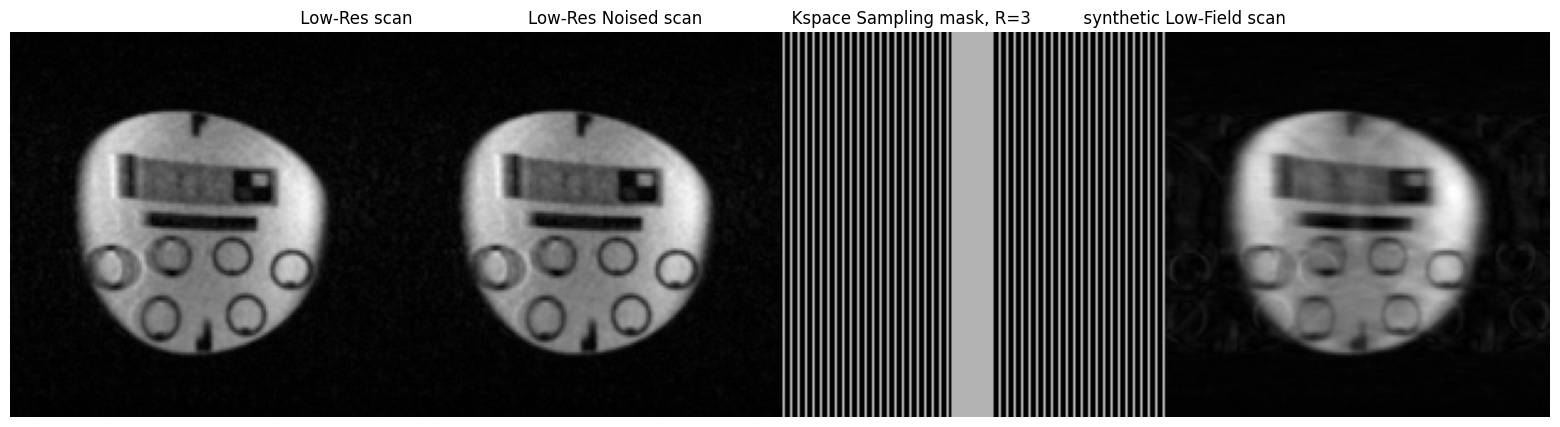

torch.Size([155, 155, 2])
torch.Size([155, 155, 2])


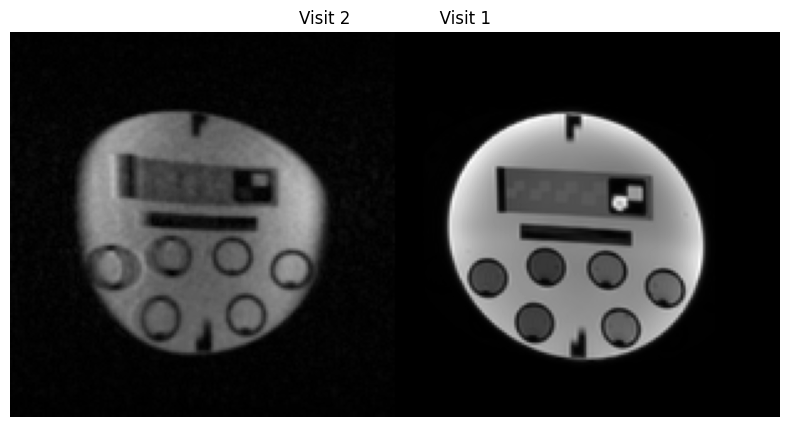

Mask torch size: (155, 155)
Acceleration factor R: 0.5256782945736435


In [157]:
im_lowres = abs(sp.ifft(sp.resize(sp.resize(kspace,(155,24)),(155,155))))
magnitude_vals = im_lowres.reshape(-1)
k = int(round(0.05 * magnitude_vals.shape[0]))
scale = magnitude_vals[magnitude_vals.argsort()[::-1][k]]
kspace = kspace/scale
target = target/scale

# Apply kspace crop on target
target_torch = cplx.to_tensor(target)
target_torch = T.ifft2( T.fft2(target_torch))
# For plot
kspace_HR = np.abs(cplx.to_numpy(T.fft2(cplx.to_tensor(target))))
kspace_LR =cplx.to_numpy( T.fft2( cplx.to_tensor(target)))
target_HR = target
target_LR = cplx.to_numpy(T.ifft2( T.kspace_crop(T.fft2( cplx.to_tensor(target)),0.67)))
target = cplx.to_numpy(target_torch)
# Convert everything from numpy arrays to tensors
kspace_torch = cplx.to_tensor(kspace).float()
kspace_torch = T.awgn_torch(kspace_torch,1000,L=1)
kspace_noised = kspace_torch.clone()
target_torch = cplx.to_tensor(target).float()

### Reference addition ###
im_lowres_ref = abs(sp.ifft(sp.resize(sp.resize(reference_kspace,(155,24)),(155,108))))
magnitude_vals_ref = im_lowres_ref.reshape(-1)
k_ref = int(round(0.05 * magnitude_vals_ref.shape[0]))
scale_ref = magnitude_vals_ref[magnitude_vals_ref.argsort()[::-1][k_ref]]
reference = reference / scale_ref
reference_torch = cplx.to_tensor(reference).float()
reference_torch_kspace = T.fft2(reference_torch)
reference_torch = T.ifft2(reference_torch_kspace)
"""
fig, axs = plt.subplots(1, 1, figsize=(5, 5))  # 1 row, 3 columns
# Plot each image in a subplot
im1 = axs.imshow(np.abs(cplx.to_numpy(mask_torch)), cmap='gray')
plt.show()
"""
#kspace_torch = kspace_torch*mask_torch

from fastmri.data import transforms, subsample
def get_mask_func(factor):
    center_fractions = 0.08 * 4/factor # RandomMaskFunc EquiSpacedMaskFunc
    mask_func = subsample.EquiSpacedMaskFunc(
    center_fractions=[center_fractions],
    accelerations=[factor], 
    )
    return mask_func
mask_func = get_mask_func(3)
kspace_torch = transforms.apply_mask(kspace_torch, mask_func)[0]

concat = np.concatenate((target,cplx.to_numpy(T.ifft2(kspace_noised)),np.abs(cplx.to_numpy(kspace_torch))!=0,cplx.to_numpy(T.ifft2(kspace_torch))),axis=1)
fig, axs = plt.subplots(1, 1, figsize=(20, 5))  # 1 row, 3 columns
# Plot each image in a subplot
im1 = axs.imshow(np.abs(concat), cmap='gray')
#im1 = axs.imshow(np.log(np.abs(cplx.to_numpy(kspace_torch))), cmap='gray')
plt.title('     Low-Res scan                      Low-Res Noised scan                 Kspace Sampling mask, R=3          synthetic Low-Field scan')
plt.axis('off')
plt.show()

fig, axs = plt.subplots(1, 1, figsize=(10, 5))  # 1 row, 3 columns
print(target_torch.shape)
print(reference_torch.shape)

concat2 = np.concatenate((cplx.to_numpy(target_torch),cplx.to_numpy(reference_torch)),axis=1)
im1 = axs.imshow(np.abs(concat2), cmap='gray')
#im1 = axs.imshow(np.log(np.abs(cplx.to_numpy(kspace_torch))), cmap='gray')
plt.title('Visit 2                 Visit 1')
plt.axis('off')
plt.show()
"""
concat = np.concatenate((target_HR,target_LR),axis=1)
fig, axs = plt.subplots(1, 1, figsize=(6, 5))  # 1 row, 3 columns
# Plot each image in a subplot
im1 = axs.imshow(np.abs(concat), cmap='gray')
#im1 = axs.imshow(np.log(np.abs(cplx.to_numpy(kspace_torch))), cmap='gray')
plt.title(' High-Res scan (1x1[mm])        Low-Res scan (1.5x1.5[mm])   ')
plt.axis('off')
plt.show()

concat = np.concatenate((kspace_HR,kspace_LR),axis=1)
fig, axs = plt.subplots(1, 1, figsize=(6, 5))  # 1 row, 3 columns
# Plot each image in a subplot
im1 = axs.imshow(np.log(np.abs(concat)), cmap='gray')
#im1 = axs.imshow(np.log(np.abs(cplx.to_numpy(kspace_torch))), cmap='gray')
plt.title(' High-Res kspace (1x1[mm])        Low-Res kspace (1.5x1.5[mm])   ')
plt.axis('off')
plt.show()
"""
mask_np = np.abs(cplx.to_numpy(kspace_torch))!=0
print(f'Mask torch size: {mask_np.shape}')
s = (172)*(108)
print(f'Acceleration factor R: {np.sum(mask_np)/s}')

In [158]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [159]:
#Hyper parameters
params = Namespace()
#params.data_path = "./registered_data/patient23b/"
params.data_path = "./registered_data/"
params.batch_size = 2
params.num_grad_steps = 1 #4
params.num_cg_steps = 8 #8
params.share_weights = True
params.modl_lamda = 0.05
params.lr = 0.00001
#params.lr = 0.0001
params.weight_decay = 0
params.lr_step_size = 7
params.lr_gamma = 0.1
params.epoch = 61
params.reference_mode = 1
params.reference_lambda = 0.1

In [160]:

checkpoint_file = "./L2_checkpoints_Sairam/model_240.pt" # obly ViT
checkpoint_file_fuser = "./L2_checkpoints_Sairam_fuser/model_240.pt"  # ViT-Fuser + PreTrain
checkpoint_file_fuser_pre = "./checkpoints_fuser_sairam_pre/model_ViTFuserPre_100.pt"  # Only PreTrain
checkpoint_file_fuser_l1l2 = "./L2_checkpoints_Sairam_fuser_tests2/model_240.pt"  # for different loss for style tests

checkpoint = torch.load(checkpoint_file,map_location=device)
checkpoint_fuser = torch.load(checkpoint_file_fuser,map_location=device)
checkpoint_fuser_l1l2 = torch.load(checkpoint_file_fuser_pre,map_location=device)
# Init model
from vision_transformer import VisionTransformer
from recon_net import ReconNet

#from UnrolledViT import UnrolledViT
from UnrolledViT_Sairam import UnrolledViT
model = UnrolledViT(params).to(device)
model_fuser = UnrolledViT(params).to(device)
model_fuser_l1l2 = UnrolledViT(params).to(device)

# load checkpoint
#cp = torch.load('./lsdir-2x+hq50k_vit_epoch_60.pt', map_location=device)
#checkpoint_file = "./L2_checkpoints_poisson_x2_FusionNetViT/model_30.pt"
model.load_state_dict(checkpoint['model'])
model_fuser.load_state_dict(checkpoint_fuser['model'])
model_fuser_l1l2.load_state_dict(checkpoint_fuser_l1l2['model'])


/tmp/ipykernel_3332030/3082972752.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file,map_location=device)
/tmp/ipykernel_3332030/308

shared weights
shared weights
shared weights


<All keys matched successfully>

torch.Size([1, 1, 155, 155])
torch.Size([155, 155, 2])
torch.Size([155, 155, 2])
torch.Size([155, 155, 1])
torch.Size([155, 155, 2])
(155, 155)
Size image: (155, 155)
Size ref: (155, 155)
Size mask: (155, 155)
shape: (256, 256)


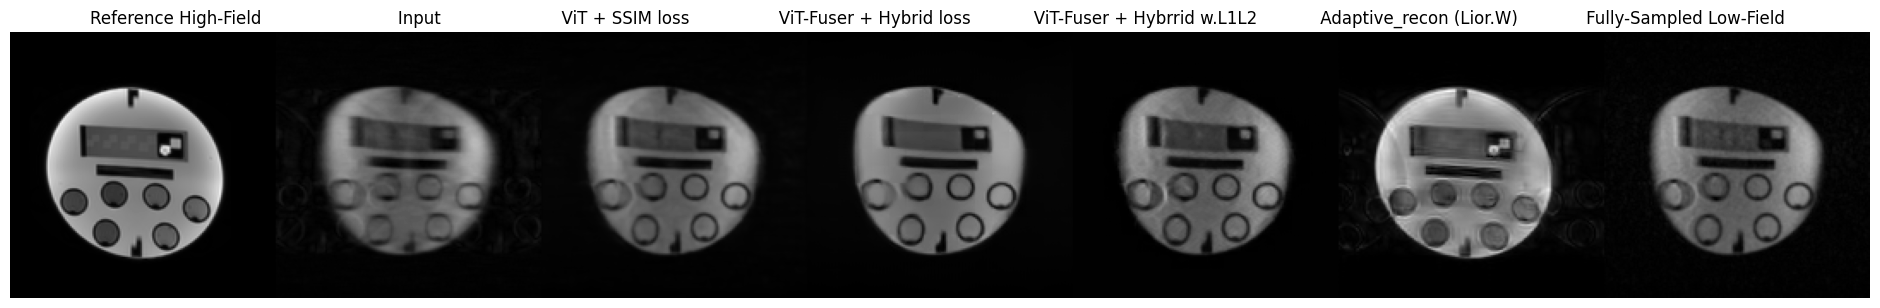

In [161]:


img = cplx.to_tensor(np.abs(cplx.to_numpy(T.ifft2(kspace_torch)))).permute(2,0,1).unsqueeze(0).to(device)
img_chan = img[:,0,:,:].unsqueeze(0)
ref = cplx.to_tensor(np.abs(cplx.to_numpy(reference_torch))).permute(2,0,1).unsqueeze(0).to(device)
ref_chan = ref[:,0,:,:].unsqueeze(0)
ref_np = ref_chan.cpu().numpy()[0,0,:,:]
print(img_chan.shape)
img_padded_np = img_chan.cpu().numpy()[0,0,:,:]

## Regular
print(kspace_torch.shape)
print(reference_torch.shape)
im_out = model(kspace_torch.float().unsqueeze(0).to(device),reference_torch.float().unsqueeze(0).to(device)).squeeze(0)
print(im_out.shape)
im_out_pad = torch.cat((im_out,torch.zeros_like(im_out)),dim=2)
print(im_out_pad.shape)
im_out = T.ifft2(T.fft2(im_out_pad))
target_torch = T.ifft2(T.fft2(cplx.to_tensor(target)))
target = cplx.to_numpy(target_torch.cpu().detach())
#merged_np = im_out.cpu().detach().numpy()[0,:,:,:]
#im_out = np.sqrt(merged_np[:,:,0]**2 + merged_np[:,:,1]**2)
im_out = np.abs(cplx.to_numpy(im_out.cpu().detach()))
#im_out = 1-(np.abs(im_out)-np.abs(target))
print(im_out.shape)

## Fuser
im_out_fuser = model_fuser(kspace_torch.float().unsqueeze(0).to(device),reference_torch.float().unsqueeze(0).to(device)).squeeze(0)
im_out_fuser_pad = torch.cat((im_out_fuser,torch.zeros_like(im_out_fuser)),dim=2)
im_out_fuser = T.ifft2(T.fft2(im_out_fuser_pad))
im_out_fuser = np.abs(cplx.to_numpy(im_out_fuser.cpu().detach()))

## Fuser with l1l2 
im_out_fuser_l1l2 = model_fuser_l1l2(kspace_torch.float().unsqueeze(0).to(device),reference_torch.float().unsqueeze(0).to(device)).squeeze(0)
im_out_fuser_pad_l1l2 = torch.cat((im_out_fuser_l1l2,torch.zeros_like(im_out_fuser_l1l2)),dim=2)
im_out_fuser_l1l2 = T.ifft2(T.fft2(im_out_fuser_pad_l1l2))
im_out_fuser_l1l2 = np.abs(cplx.to_numpy(im_out_fuser_l1l2.cpu().detach()))

## CS Lior Weizman
mask = np.abs(cplx.to_numpy(kspace_torch))!=0
print(f'Size image: {np.abs(cplx.to_numpy(T.ifft2(kspace_torch))).shape}')
print(f'Size ref: {(np.abs(cplx.to_numpy(reference_torch))).shape}')
print(f'Size mask: {mask.shape}')
target_shape = (256, 256)
def pad_array(array, target_shape):
    pad_height = (target_shape[0] - array.shape[0]) // 2
    pad_width = (target_shape[1] - array.shape[1]) // 2
    return np.pad(array, ((pad_height, pad_height+1), (pad_width, pad_width+1)), mode='constant')
padded_input = pad_array(np.abs(cplx.to_numpy(T.ifft2(kspace_torch))), target_shape)
padded_ref = pad_array((np.abs(cplx.to_numpy(reference_torch))), target_shape)
padded_mask= pad_array(mask, target_shape)

print(f'shape: {padded_mask.shape}')
adaptive_recon = ut.adaptive_CS_reconstruction(padded_input.copy(), padded_ref.copy(), 20,padded_mask.copy())

def crop_array(array, original_shape):
    crop_height = (array.shape[0] - original_shape[0]) // 2
    crop_width = (array.shape[1] - original_shape[1]) // 2
    return array[crop_height:crop_height + original_shape[0], crop_width:crop_width + original_shape[1]]

adaptive_recon_cropped = crop_array(adaptive_recon, np.abs(cplx.to_numpy(T.ifft2(kspace_torch))).shape)

# Concatenate images horizontally
concatenated_image = np.concatenate((ref_np,img_padded_np, im_out, im_out_fuser,im_out_fuser_l1l2,np.abs(adaptive_recon_cropped),np.abs(target)),axis=1)
# Plot the concatenated image
plt.figure(figsize=(24, 12))
plt.imshow(concatenated_image, cmap='gray')
plt.title('Reference High-Field                          Input                       ViT + SSIM loss                 ViT-Fuser + Hybrid loss            ViT-Fuser + Hybrrid w.L1L2            Adaptive_recon (Lior.W)             Fully-Sampled Low-Field ')
plt.axis('off')
plt.show()


In [162]:
kspace_torch.shape
reference_torch.shape

torch.Size([155, 155, 2])

(155, 155)


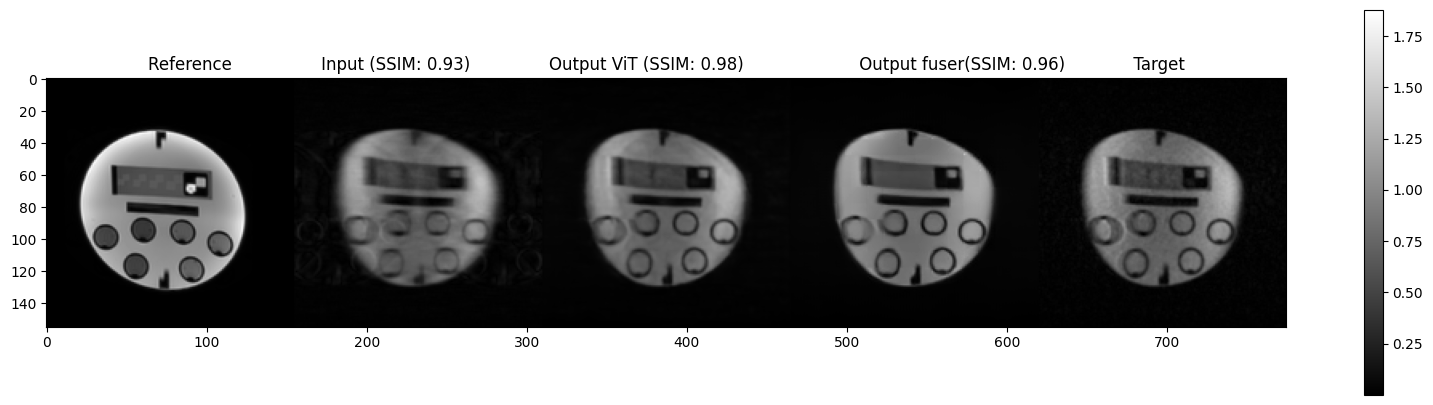

In [163]:
from skimage.metrics import structural_similarity as ssim
from scipy.ndimage import binary_fill_holes
def compute_psnr(img1, img2, maxval):
    """Computes PSNR in dB"""
    mse = np.mean((img1 - img2) ** 2)

    return (10 * np.log10(maxval / mse)).item()
cplx_image_target = target
cplx_image_in = img_padded_np
cplx_image_out = im_out
cplx_image_out_fuser = im_out_fuser

cplx_image_reference = ref_np
maxval = np.max(np.abs(np.concatenate((cplx_image_target,cplx_image_in,cplx_image_out,cplx_image_out_fuser),axis=0)))
minval = np.min(np.abs(np.concatenate((cplx_image_target,cplx_image_in,cplx_image_out,cplx_image_out_fuser),axis=0)))

target_numpy_norm = np.abs(cplx_image_target)/maxval
input_numpy_norm = np.abs(cplx_image_in)/maxval
out_numpy_norm = np.abs(cplx_image_out)/maxval
out_fuser_numpy_norm = np.abs(cplx_image_out_fuser)/maxval

# Area calib
# Find comparison area:
area = target_numpy_norm > 0.30
kernel = np.ones((10, 10)) / 25.0
#area = np.convolve(area, kernel, mode='constant', cval=0.0)
area = scipy.ndimage.convolve(area.astype(float), kernel, mode='constant', cval=0.0)
area[area>0.009] = 1
structuring_element = np.ones((4,4))
area = binary_closing(area, structure=structuring_element)
area = binary_fill_holes(area)

target_numpy_norm = target_numpy_norm * area
input_numpy_norm = input_numpy_norm * area
out_numpy_norm = out_numpy_norm * area
out_fuser_numpy_norm = out_fuser_numpy_norm * area


psnr_in = compute_psnr(target_numpy_norm, input_numpy_norm,1)
psnr_out = compute_psnr(target_numpy_norm,out_numpy_norm,1)
data_range = maxval - minval
ssim_in, _ = ssim(target_numpy_norm, input_numpy_norm, data_range=data_range, full=True)
ssim_out, _ = ssim(target_numpy_norm, out_numpy_norm, data_range=data_range, full=True)
ssim_out_fuser, _ = ssim(target_numpy_norm, out_fuser_numpy_norm, data_range=data_range, full=True)

print(cplx_image_out.shape)
plt_concat = np.concatenate((np.abs(cplx_image_reference),np.abs(cplx_image_in),np.abs(cplx_image_out),np.abs(cplx_image_out_fuser),np.abs(cplx_image_target)),axis=1)
fig, axs = plt.subplots(1, 1, figsize=(20, 5))  # 1 row, 3 columns
im = axs.imshow(plt_concat, cmap='gray')
axs.set_title(f'Reference                 Input (SSIM: {ssim_in:.2f})               Output ViT (SSIM: {ssim_out:.2f})                      Output fuser(SSIM: {ssim_out_fuser:.2f})             Target')
#axs.set_title(f'Reference                         Input                         Output                                 Target')
fig.colorbar(im, ax=axs)
plt.show()




(155, 155)
(155, 155)
(155, 155)


/tmp/ipykernel_3332030/566286739.py:11: RuntimeWarning: divide by zero encountered in log
  im = axs.imshow(np.log(np.abs(plt_concat)), cmap='gray')


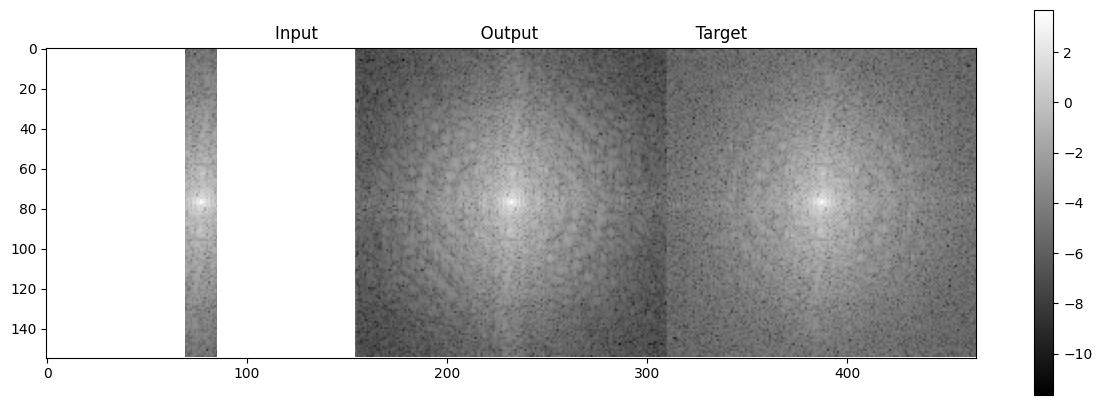

/tmp/ipykernel_3332030/566286739.py:16: RuntimeWarning: divide by zero encountered in log
  pl.ImagePlot(np.log(np.abs(plt_concat).astype(float)))


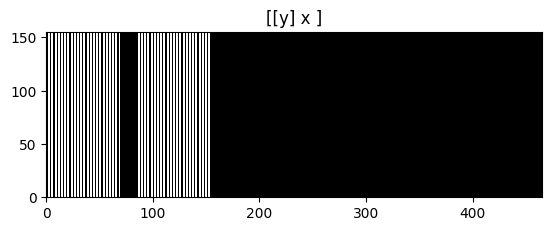

In [164]:

print(cplx_image_target.shape)
print(cplx_image_in.shape)
print(cplx_image_out.shape)
# Create a figure and axes
kspace_in = cplx.to_numpy(kspace_torch)
kspace_out = cplx.to_numpy(T.fft2((cplx.to_tensor(cplx_image_out))))
kspace_target = cplx.to_numpy(T.fft2((cplx.to_tensor(cplx_image_target))))

plt_concat = np.concatenate((kspace_in,kspace_out,kspace_target),axis=1)
fig, axs = plt.subplots(1, 1, figsize=(15, 5))  # 1 row, 3 columns
im = axs.imshow(np.log(np.abs(plt_concat)), cmap='gray')
axs.set_title('Input                               Output                              Target')
fig.colorbar(im, ax=axs)
plt.show()

pl.ImagePlot(np.log(np.abs(plt_concat).astype(float)))

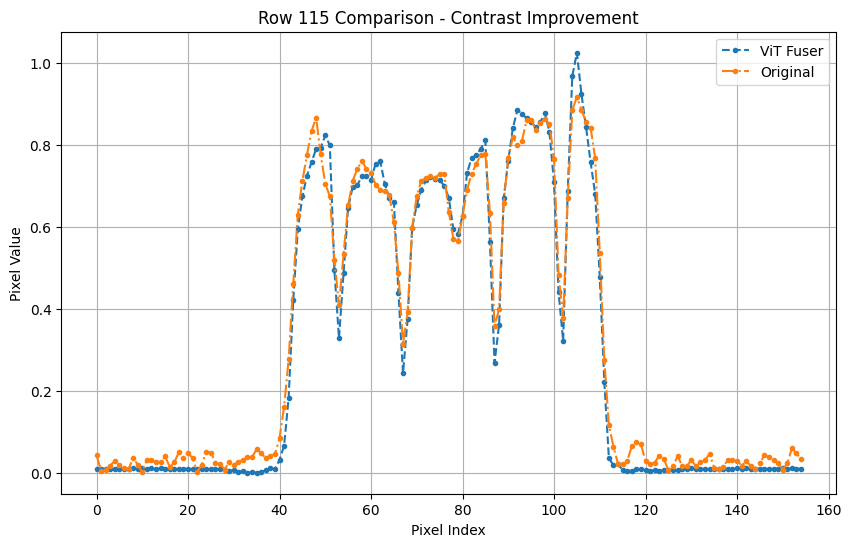

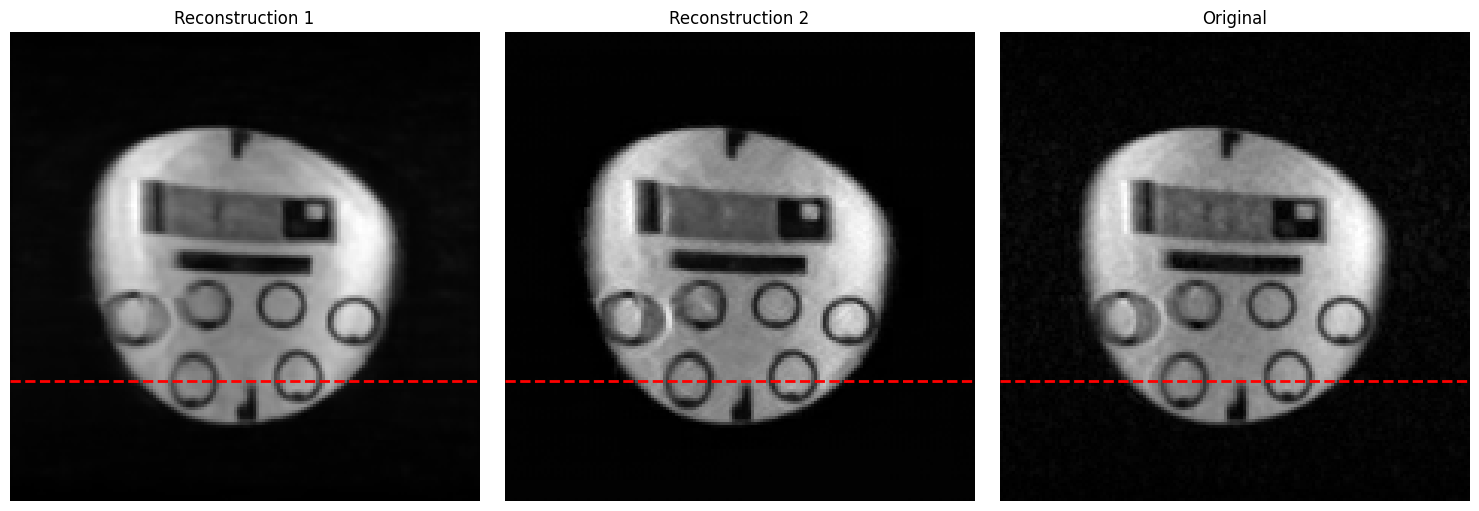

In [165]:
plt_concat = np.concatenate((np.abs(cplx_image_reference),np.abs(cplx_image_in),np.abs(cplx_image_out),np.abs(cplx_image_out_fuser),np.abs(cplx_image_target)),axis=1)

reconstruction1  = np.abs(cplx_image_out)
reconstruction2 = np.abs(im_out_fuser_l1l2)
original = np.abs(cplx_image_target)

# Extract row 70 from each image
row_number = 115 # 4
#row_number = 90 # 12

row1 = reconstruction1[row_number, :]
row2 = reconstruction2[row_number, :]
row_original = original[row_number, :]

# Plot the rows to compare contrast
plt.figure(figsize=(10, 6))
#plt.plot(row1, label="ViT", linestyle='-', marker='.')
plt.plot(row2, label="ViT Fuser", linestyle='--', marker='.')
plt.plot(row_original, label="Original", linestyle='-.', marker='.')
plt.title(f"Row {row_number} Comparison - Contrast Improvement")
plt.xlabel("Pixel Index")
plt.ylabel("Pixel Value")
plt.legend()
plt.grid(True)
plt.show()

# Plot the images with the selected line highlighted
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
images = [reconstruction1, reconstruction2, original]
titles = ["Reconstruction 1", "Reconstruction 2", "Original"]

for ax, img, title in zip(axes, images, titles):
    ax.imshow(img, cmap='gray', interpolation='nearest')
    ax.axhline(y=row_number, color='red', linestyle='--', linewidth=2)  # Highlight the selected row
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [166]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

# pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import models, transforms
import torchvision

model_ft = models.vgg16(weights='DEFAULT').requires_grad_(False)